In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
ca_users_path = '/content/drive/MyDrive/CMPE256/Data/CSVfiles/CA_users.csv'
ca_review_path = '/content/drive/MyDrive/CMPE256/Data/CSVfiles/California_reviews.csv'
business_path = '/content/drive/MyDrive/CMPE256/Data/CSVfiles/business.csv'

In [8]:
!pip install scikit-surprise
from surprise import SVD, SVDpp

     |████████████████████████████████| 11.8 MB 11.4 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630117 sha256=35edcdd684a9245d21062c71e6cfbe9967f7efaa6e8842bb900372fdf0905e83
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [9]:
import pandas as pd
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import KFold
import matplotlib.pyplot as plt


# from surprise.prediction_algorithms.matrix_factorization import SVDpp

# Creating Dataframes

In [10]:
reviews = pd.read_csv(ca_review_path, usecols= ['business_id', 'stars', 'review_id', 'user_id'])
business = pd.read_csv(business_path, usecols= ['business_id', 'name'])
users = pd.read_csv(ca_users_path, usecols= ['user_id', 'is_elite'])

Since users and business dataframe both have the same column names we will update them accordingly


In [11]:
users = users.rename(columns = { 'name': 'Username' })
business = business.rename(columns = { 'name': 'Restaurant name' })

In [12]:
reviews.columns
reviews.head()

,review_id,user_id,business_id,stars
0,pUycOfUwM8vqX7KjRRhUEA,59MxRhNVhU9MYndMkz0wtw,gebiRewfieSdtt17PTW6Zg,3.0
1,eCiWBf1CJ0Zdv1uVarEhhw,OhECKhQEexFypOMY6kypRw,vC2qm1y3Au5czBtbhc-DNw,4.0
2,YbMyvlDA2W3Py5lTz8VK-A,4hBhtCSgoxkrFgHa4YAD-w,bbEXAEFr4RYHLlZ-HFssTA,5.0
3,L0jv8c2FbpWSlfNC6bbUEA,bFPdtzu11Oi0f92EAcjqmg,IDtLPgUrqorrpqSLdfMhZQ,5.0
4,4zopEEPqfwm-c_FNpeHZYw,JYYYKt6TdVA4ng9lLcXt_g,SZU9c8V2GuREDN5KgyHFJw,5.0


In [13]:

business.columns


Index(['business_id', 'Restaurant name'], dtype='object')

In [14]:
users.columns


Index(['user_id', 'is_elite'], dtype='object')

In [15]:
users.head()

,user_id,is_elite
0,qVc8ODYU5SZjKXVBgXdI7w,True
1,SZDeASXq7o05mMNLshsdIA,True
2,q_QQ5kBBwlCcbL1s4NVK3g,True
3,iYzhPPqnrjJkg1JHZyMhzA,False
4,QF1Kuhs8iwLWANNZxebTow,True


## Elite Reviews Only

In [16]:
elite_reviews_df = reviews.merge(users, how='left', on=['user_id'], indicator=True)
elite_reviews_df.shape

(239065, 6)

In [17]:
elite_reviews_df = elite_reviews_df.loc[elite_reviews_df['is_elite'] == True]
elite_reviews_df.shape

(48367, 6)

In [18]:
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, business id and stars (in that order).
data = Dataset.load_from_df(elite_reviews_df[['user_id', 'business_id', 'stars']], reader)

# Collaborative filtering using cross validation and hyperparameter tuning

## 1. SVD

In [19]:
SVD_rmses = []
kfolds_SVD = [3,5,6]
n_split_to_best_param_grid = dict()
n_split_to_best_rmse = dict()

https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD

###Performing cross validations with different folds

In [20]:
def crossValidation(nsplit,algo, param_grid):
    kf = KFold(n_splits=nsplit, random_state=2,shuffle = True)
    return GridSearchCV(algo_class=algo, param_grid = param_grid, measures=['rmse'], cv=kf)

###Calculating the best paramters for SVD model to fetch best RMSE score

In [21]:
def SVD_hyperparamter_tuning(kfolds):
  param_grid_SVD = {
  'n_factors':[5,8,10,15,20,25],
  'n_epochs': [10, 20, 30, 40], 
  'lr_all': [0.005, 0.007],
  'reg_all': [0.01,0.03,0.05,0.07],
  }
  for elem in kfolds_SVD:
    gs_model = crossValidation(elem, SVD, param_grid_SVD)
    gs_model.fit(data)
    print(f"With kFold as {elem}: ", gs_model.best_params)
    n_split_to_best_param_grid[elem] = gs_model.best_params
    print(f"With kFold as {elem}: ", gs_model.best_score['rmse'])
    n_split_to_best_rmse[elem] = gs_model.best_score['rmse']

In [22]:
SVD_hyperparamter_tuning(kfolds_SVD)

With kFold as 3:  {'rmse': {'n_factors': 8, 'n_epochs': 20, 'lr_all': 0.007, 'reg_all': 0.07}}
With kFold as 3:  0.936755728700514
With kFold as 5:  {'rmse': {'n_factors': 15, 'n_epochs': 20, 'lr_all': 0.007, 'reg_all': 0.07}}
With kFold as 5:  0.9338945407646622
With kFold as 6:  {'rmse': {'n_factors': 25, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.07}}
With kFold as 6:  0.931799275382302


In [23]:
print(n_split_to_best_param_grid)

{3: {'rmse': {'n_factors': 8, 'n_epochs': 20, 'lr_all': 0.007, 'reg_all': 0.07}}, 5: {'rmse': {'n_factors': 15, 'n_epochs': 20, 'lr_all': 0.007, 'reg_all': 0.07}}, 6: {'rmse': {'n_factors': 25, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.07}}}


In [24]:
def fetch_params(param_grid):
    return param_grid['n_factors'], param_grid['n_epochs'], param_grid['lr_all'], param_grid['reg_all']
   
# for n_split,param_grid in n_split_to_best_param_grid.items():
#   fetch_params(param_grid['rmse'])

###1. Training the model over the trainset with the hyperparamters
###2. Evaluating the model over the testset to check how does it perform

In [25]:
def train_and_test_model():
  SVD_rmses = []
  for n_split,param_grid in n_split_to_best_param_grid.items():
    n_factors, n_epochs, lr_all, reg_all = fetch_params(param_grid['rmse'])
    kf = KFold(n_splits=n_split)
    algo = SVD(n_factors = n_factors, n_epochs = n_epochs, lr_all = lr_all, reg_all = reg_all)
    scores = []
    for trainset, testset in kf.split(data):
        # train and test algorithm.
        algo.fit(trainset)
        predictions = algo.test(testset)
        # Compute and print Root Mean Squared Error
        print(f"RMSE for {n_split}:")
        rmse = accuracy.rmse(predictions)
        scores.append(rmse)
        # print(f"RMSE for {n_split}: ",rmse)
    SVD_rmses.append(min(scores))
  return SVD_rmses

In [26]:
SVD_rmses = train_and_test_model()

RMSE for 3:
RMSE: 0.9462
RMSE for 3:
RMSE: 0.9354
RMSE for 3:
RMSE: 0.9297
RMSE for 5:
RMSE: 0.9315
RMSE for 5:
RMSE: 0.9343
RMSE for 5:
RMSE: 0.9380
RMSE for 5:
RMSE: 0.9304
RMSE for 5:
RMSE: 0.9381
RMSE for 6:
RMSE: 0.9308
RMSE for 6:
RMSE: 0.9458
RMSE for 6:
RMSE: 0.9253
RMSE for 6:
RMSE: 0.9450
RMSE for 6:
RMSE: 0.9406
RMSE for 6:
RMSE: 0.9218


In [27]:
print(SVD_rmses)
def plot(kfolds, rmses, algo):
  plt.plot(kfolds, rmses)
  plt.ylabel('RMSE Scores')
  plt.xlabel('k splits')
  plt.savefig(f"{algo}_RMSE_to_k_splits.png")

[0.9296990220742862, 0.9304214086581829, 0.9218375476615595]


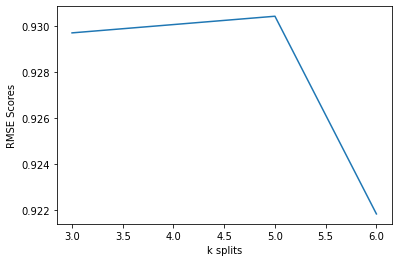

In [28]:
kfolds_SVD = [3,5,6]
plot(kfolds_SVD, SVD_rmses, "SVD")

## 2. SVDpp

In [29]:
SVDpp_rmses = []
kfolds_SVDpp = [3,5,6]
n_split_to_best_param_grid_SVDpp = dict()
n_split_to_best_rmse_SVDpp = dict()

In [32]:
def SVDpp_hyperparamter_tuning(kfolds):
  param_grid_SVDpp = {
    'n_factors':[5,8,10,15,20],
    'n_epochs': [20,30,40], 
    'lr_all': [0.005, 0.007],
    'reg_all': [0.05,0.07],
  }
  for elem in kfolds:
    gs_model = crossValidation(elem, SVDpp, param_grid_SVDpp)
    gs_model.fit(data)
    print(f"With kFold as {elem}: ", gs_model.best_params)
    n_split_to_best_param_grid_SVDpp[elem] = gs_model.best_params
    print(f"With kFold as {elem}: ", gs_model.best_score['rmse'])
    n_split_to_best_rmse_SVDpp[elem] = gs_model.best_score['rmse']

In [ ]:
SVDpp_hyperparamter_tuning(kfolds_SVDpp)

With kFold as 3:  {'rmse': {'n_factors': 10, 'n_epochs': 20, 'lr_all': 0.007, 'reg_all': 0.07}}
With kFold as 3:  0.9365338521996399


In [ ]:
def train_and_test_model_SVDpp():
  SVD_rmsespp = []
  for n_split,param_grid in n_split_to_best_param_grid_SVDpp.items():
    n_factors, n_epochs, lr_all, reg_all = fetch_params(param_grid['rmse'])
    kf = KFold(n_splits=n_split)
    algo = SVDpp(n_factors = n_factors, n_epochs = n_epochs, lr_all = lr_all, reg_all = reg_all)
    scores = []
    for trainset, testset in kf.split(data):
        # train and test algorithm.
        algo.fit(trainset)
        predictions = algo.test(testset)
        # Compute and print Root Mean Squared Error
        print(f"RMSE for {n_split}:")
        rmse = accuracy.rmse(predictions)
        scores.append(rmse)
        # print(f"RMSE for {n_split}: ",rmse)
    SVDpp_rmses.append(min(scores))
  return SVDpp_rmses

In [ ]:
SVDpp_rmses = train_and_test_model_SVDpp()

In [ ]:
plot(kfolds_SVDpp, SVDpp_rmses, "SVDpp")

##Comparing SVD versus SVDpp

In [ ]:
plt.plot(kfolds_SVDpp, SVDpp_rmses)
plt.plot(kfolds_SVD, SVD_rmses)
plt.ylabel('RMSE Scores')
plt.xlabel('k splits')
plt.savefig("SVD_versusus_SVDpp_RMSE_to_k_splits.png")